In [11]:
import pandas as pd
from pathlib import Path

def merge_with_overlap(paths, 
                       date_col: str, 
                       value_col: str, 
                       overlap_days: int = 7) -> pd.Series:
    """
    ダウンロード済みの複数 CSV を
      – overlap_days 日だけ重ねて取得
      – 重複期間の平均比で補正
      – スムーズに連結
    するユーティリティ関数です。
    """
    # 1) 各チャンクを pd.Series に読み込む
    chunks = []
    for p in paths:
        df = pd.read_csv(p, parse_dates=[date_col])
        s = pd.Series(df[value_col].values,
                      index=df[date_col],
                      name=value_col)
        # 重複インデックスは先行チャンク優先
        s = s[~s.index.duplicated(keep="first")]
        chunks.append(s)

    # 2) 最初のチャンクをベースに
    merged = chunks[0].copy()

    # 3) 以降のチャンクを順次マージ
    for nxt in chunks[1:]:
        # このチャンクの “オーバーラップ” 該当日を取得
        head = nxt.index[:overlap_days]
        common = merged.index.intersection(head)
        if len(common) < overlap_days:
            raise ValueError(f"オーバーラップが不足：期待 {overlap_days} 日, 実際 {len(common)} 日")
        # 重複日における前後チャンクの比率を平均して算出
        scale = (merged.loc[common] / nxt.loc[common]).mean()
        # 新チャンク全体に補正をかける
        nxt_scaled = nxt * scale
        # 重複日は飛ばして連結
        tail = nxt_scaled.loc[~nxt_scaled.index.isin(common)]
        merged = pd.concat([merged, tail])

    return merged.sort_index()


# ----------------------------------------------------
# 使い方例
# ----------------------------------------------------
if __name__ == "__main__":
    csv_dir = Path("../../../Predict_sales/csv/GoogleTrend/古着")
    paths = [
        csv_dir / "trend_2021-06-16_2022-03-11.csv",
        csv_dir / "trend_2022-03-05_2022-11-28.csv",
        csv_dir / "trend_2022-11-22_2023-08-17.csv",
        csv_dir / "trend_2023-08-11_2024-05-05.csv",
        csv_dir / "trend_2024-04-29_2025-01-22.csv",
        csv_dir / "trend_2025-01-16_2025-04-18.csv",
    ]

    # チャンクを平均比率で補正・連結
    trend_daily = merge_with_overlap(
        paths,
        date_col="date",       # CSV の日付列名
        value_col="古着",      # CSV の値列名
        overlap_days=7         # 7日オーバーラップ
    )

    trend_daily = trend_daily.round(2)   # 小数第2位まで
    
    # 結果を保存
    trend_daily.to_csv("used_clothing_trend_daily_merged.csv", header=["gt_古着"])


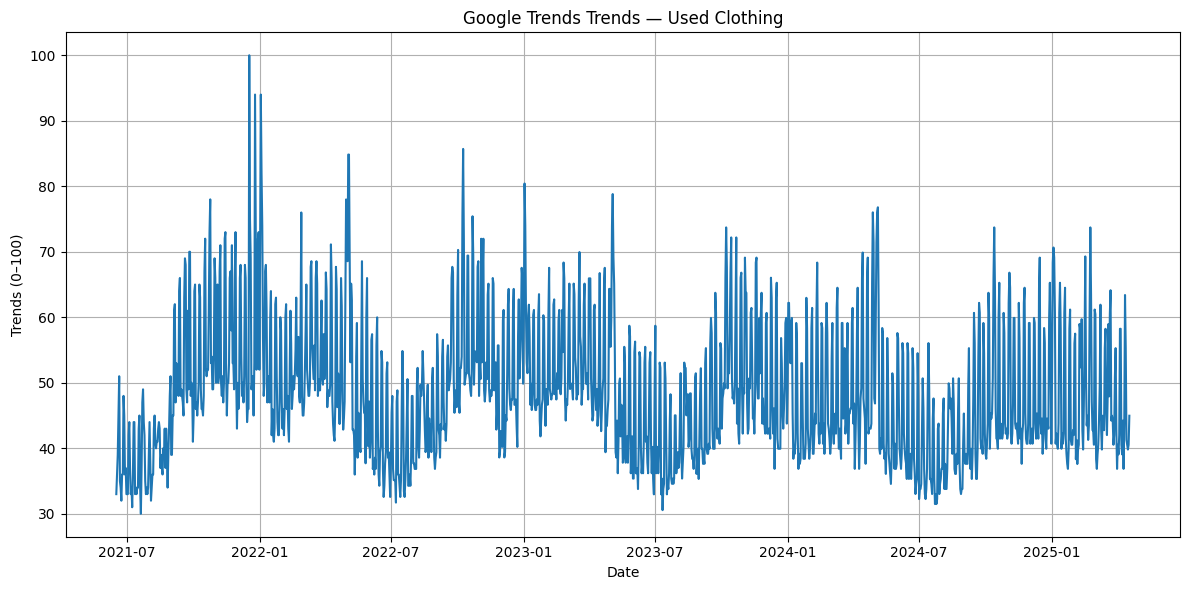

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# マージ済みトレンドデータを読み込む
trend_daily = pd.read_csv(
    "../../../Predict_sales/csv/GoogleTrend/古着/used_clothing_trend_daily_merged.csv",  # ファイルパスを適宜変更
    index_col=0,
    parse_dates=True,
    
)

# グラフ描画
plt.figure(figsize=(12, 6))
plt.plot(trend_daily.index, trend_daily.values)
plt.title("Google Trends Trends — Used Clothing")
plt.xlabel("Date")
plt.ylabel("Trends (0–100)")
plt.grid(True)
plt.tight_layout()
plt.show()
